# VehCANSigLyzer

In this notebook, we extract and select features from CAN-MIRGU, which is a dataset of raw CAN frames collected from a single vehicle by [Rajapaksha et al. (2024)](https://www.ndss-symposium.org/ndss-paper/auto-draft-482/).

**Data**: The dataset used is [CAN-MIRGU](https://github.com/sampathrajapaksha/CAN-MIRGU), which contains both benign and attack data from an unknown 2016 vehicle model. It is a fully electric vehicle with full autonomous driving capabilities. 

**DBC**: We use a DBC obtained from [opendbc](https://github.com/commaai/opendbc), which is an open-source repository of reverse-engineered DBC files contributed by car hacking enthusiasts. 

The paper does not reveal the exact model of the test vehicle, except for the aforementioned details. Apart from this, the AIDs and some associated signals (from the dataset and attack metadata) are known and a [video](https://www.youtube.com/watch?v=CufiACr2Zs8) of the attacks being conducted while the car is being driven is available. However, the car is most likely a Kia since the interior of the test car is a visual match for Kia car interiors from 2016 and we find all the AIDs used in the attacks in the [hyundai_kia_generic.dbc](https://github.com/commaai/opendbc/blob/master/opendbc/dbc/hyundai_kia_generic.dbc) file. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import pickle
import os
import cantools
from importlib import reload
from tqdm import tqdm
import random

import helper_functions
from helper_functions import *
import gc

from sklearn.model_selection import train_test_split
from scipy.stats import shapiro
from sklearn.feature_selection import mutual_info_classif, f_classif, VarianceThreshold
from matplotlib_venn import venn3

In [2]:
# Create DataFrame for summary stats
summary_stats = pd.DataFrame(columns=['Log', 'Type', 'Real/Simulated', 'No. of benign frames', 'No. of attack frames', 'Total no. of frames', 'Total duration', 'Start timestamp', 'End timestamp'])

In [3]:
# Read in benign files
dfs_benign = {}                             # List of all preprocessed benign logs

print("Reading benign files..")
for i in tqdm(range(1, 7)):
    fpath = "CAN-MIRGU/Benign/Day_" + str(i) + "/"
    for lname in os.listdir(fpath):
        # print(lname)
        df = pd.read_csv(fpath + lname)     # Read in log
        df = preprocessDataset(df)          # Preprocess into tabular form
        df['attack_class'] = '0'              # Add attack class column      
        dfs_benign[lname] = df              # Append to list of benign logs

        duration = df.timestamp[len(df) - 1] - df.timestamp[0]
        summary_stats = pd.concat([summary_stats if not summary_stats.empty else None, pd.DataFrame([[lname, 'Benign', 'Real', len(df), 0, len(df), duration, df.timestamp[0], df.timestamp[len(df) - 1]]], columns=summary_stats.columns)], ignore_index=True)

# Save list of benign log names
benign_lnames = list(dfs_benign.keys())

Reading benign files..


  0%|          | 0/6 [00:01<?, ?it/s]


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
# Read in real attack files
dfs_attack = {}

fpath = "CAN-MIRGU/Attack/Real_attacks/"
attack_lnames = list(os.listdir(fpath))

print("Reading real attack files..")
for i in tqdm(range(len(attack_lnames))):
    lname = attack_lnames[i]
    # print(lname)
    df = pd.read_csv(fpath + lname)     # Read in log
    df = preprocessDataset(df)          # Preprocess into tabular form
    df['attack_class'] = '0'              # Add attack class column
    dfs_attack[lname] = df              # Append to list of attack logs  

    benign_frames = len(df[df.attack == '0'])
    duration = df.timestamp[len(df) - 1] - df.timestamp[0]
    summary_stats = pd.concat([summary_stats, pd.DataFrame([[lname, 'Attack', 'Real', benign_frames, len(df)-benign_frames, len(df), duration, df.timestamp[0], df.timestamp[len(df) - 1]]], columns=summary_stats.columns)], ignore_index=True)

# Save list of attack log names
attack_lnames = list(dfs_attack.keys())

with open('output/attack_lnames', 'wb') as fp:
    pickle.dump(attack_lnames, fp)

In [ ]:
# Read in simulated attack files

dfs_simulated_attack = {}

# Suspension attacks
fpath = "CAN-MIRGU/Attack/Suspension_attacks/"
simulated_attack_lnames = list(os.listdir(fpath))

print("Reading suspension attack files..")
for i in tqdm(range(len(simulated_attack_lnames))):
    lname = simulated_attack_lnames[i]
    df = pd.read_csv(fpath + lname)     # Read in log
    df = preprocessDataset(df)          # Preprocess into tabular form
    df['attack_class'] = '0'             # Add attack class column
    dfs_simulated_attack[lname] = df    # Append to list of attack logs  

    benign_frames = len(df[df.attack == '0'])
    duration = df.timestamp[len(df) - 1] - df.timestamp[0]
    summary_stats = pd.concat([summary_stats, pd.DataFrame([[lname, 'Attack', 'Simulated', benign_frames, len(df)-benign_frames, len(df), duration, df.timestamp[0], df.timestamp[len(df) - 1]]], columns=summary_stats.columns)], ignore_index=True)

# Masquerade attacks
fpath = "CAN-MIRGU/Attack/Masquerade_attacks/"   
simulated_attack_lnames = list(os.listdir(fpath))

print("Reading masquerade attack files..")
for i in tqdm(range(len(simulated_attack_lnames))):
    lname = simulated_attack_lnames[i]
    df = pd.read_csv(fpath + lname)     # Read in log
    df = preprocessDataset(df)          # Preprocess into tabular form
    df['attack_class'] = '0'              # Add attack class column
    dfs_simulated_attack[lname] = df    # Append to list of attack logs  

    benign_frames = len(df[df.attack == '0'])
    duration = df.timestamp[len(df) - 1] - df.timestamp[0]
    summary_stats = pd.concat([summary_stats, pd.DataFrame([[lname, 'Attack', 'Simulated', benign_frames, len(df)-benign_frames, len(df), duration, df.timestamp[0], df.timestamp[len(df) - 1]]], columns=summary_stats.columns)], ignore_index=True)

simulated_attack_lnames = list(dfs_simulated_attack.keys())   # Save list of attack log names


In [ ]:
# Print summary stats
print("Summary stats for all logs")
print("--------------------------")
display(summary_stats)      # Per log
summary_stats.to_csv("output/summary_stats.csv", index=False, index_label=False)
print("No. of benign logs         =", len(dfs_benign))
print("No. of attack logs         =", len(dfs_attack))
print()
print("Total no. of benign frames =", sum(summary_stats['No. of benign frames']))
print("Total no. of attack frames =", sum(summary_stats['No. of attack frames']))
print("Total no. of frames        =", sum(summary_stats['Total no. of frames']))
print()

# Real attacks only
print("Summary for real attack logs")
print("----------------------------")
print("No. of real attack logs    =", len(summary_stats[summary_stats['Real/Simulated'] == 'Real']))
print()
print("Total no. of benign frames =", (summary_stats[summary_stats['Real/Simulated'] == 'Real'])['No. of benign frames'].sum())
print("Total no. of attack frames =", (summary_stats[summary_stats['Real/Simulated'] == 'Real'])['No. of attack frames'].sum())
print("Total no. of frames        =", (summary_stats[summary_stats['Real/Simulated'] == 'Real'])['Total no. of frames'].sum())

In [ ]:
# Check sample
print('Benign_day1_file1.log')
print('---------------------')
display(dfs_benign['Benign_day1_file1.log'].head())

print('Fuzzing_random_IDs.log')
print('----------------------')
display(dfs_attack['Fuzzing_random_IDs.log'].head())

## Labelling

We convert the binary labels in the real attack datasets to multiclass labels indicating the attack type:

| Label | Attack type             | 
|-------|-------------------------|
| 0     | Benign                  | 
| 1     | Denial of service (DoS) |
| 2     | Fuzzing                 | 
| 3     | Spoofing (Targeted ID)  | 
| 4     | Replay                  |

We convert the binary labels in the simulated attack datasets in the following way: 
| Label | Attack type             | 
|-------|-------------------------|
| 0     | Benign                  | 
| 5     | Suspension              |
| 6     | Masquerade              |

In [ ]:
# Real attack types, only logs with single attack type
attack_label_dict = {
    "1" : ["DoS_attack.log"],
    "2" : ["Fuzzing_random_IDs.log", "Fuzzing_valid_IDs.log"],
    "3" : ["Steering_angle_attack.log", "Break_and_fog_light_attack.log", "Break_warning_attack.log", "Drive_mode_changing_attack.log", "FCA_warning_attack.log", "Power_steering_attack.log", "Max_speedometer_attack.log", "Min_speedometer_attack_1.log",  "Min_speedometer_attack_2.log", "Min_speedometer_attack_3.log", "Wiper_warning_attack.log", "EMS_attack.log", "Parking_break_attack.log", "Gear_shifter_attack_1.log", "Gear_shifter_attack_2.log", "Door_open_warning_attack.log"],
    "4" : ["EMS_replay_attack.log", "EMS_replay_long_attack.log", "Steering_angle_replay.log"]
}

for key in attack_label_dict.keys():
    for lname in attack_label_dict[key]:
        # dfs_attack[lname].loc[dfs_attack[lname]['attack'] == "1", 'attack'] = key
        dfs_attack[lname].loc[dfs_attack[lname]['attack'] == "1", 'attack_class'] = key

In [ ]:
# There are 4 logs with multiple windows of mixed attack type
# Although JSON metadata is available, we choose to label these messages manually

# Labelling mixed attack logs

# 1. Fuzzing + DoS
lname = "Fuzzing_valid_IDs_DoS.log"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698322348.170193) & (dfs_attack[lname].timestamp <= 1698322359.125561) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "1"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698322411.631589) & (dfs_attack[lname].timestamp <= 1698322412.975203) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "2"

# # 2. Reverse speedometer spoofing + Fuzzing
lname = "Reverse_speedometer_fuzzing_attack.log"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698324056.378570) & (dfs_attack[lname].timestamp <= 1698324077.578847) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "3"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698324112.495487) & (dfs_attack[lname].timestamp <= 1698324114.937510) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "2"

# # 3. Multiple attacks - 1
lname = "Multiple_attacks_1.log"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698324526.792025) & (dfs_attack[lname].timestamp <= 1698324665.423766) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "3"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698324741.986758) & (dfs_attack[lname].timestamp <= 1698324888.386439) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "3"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698324989.299539) & (dfs_attack[lname].timestamp <= 1698325020.489142) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "3"

# # 4. Multiple attacks - 2
lname = "Multiple_attacks_2.log"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698325268.088982) & (dfs_attack[lname].timestamp <= 1698325445.142059) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "3"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698325547.014587) & (dfs_attack[lname].timestamp <= 1698325677.014188) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "3"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698325749.869002) & (dfs_attack[lname].timestamp <= 1698325855.270239) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "3"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698325910.117414) & (dfs_attack[lname].timestamp <= 1698326015.332354) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "3"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698326059.786127) & (dfs_attack[lname].timestamp <= 1698326100.519047) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "2"
dfs_attack[lname].loc[(dfs_attack[lname].timestamp >= 1698326212.341763) & (dfs_attack[lname].timestamp <= 1698326238.622524) & (dfs_attack[lname].attack == '1'), 'attack_class'] = "2"

In [ ]:
# Labelling simulated attack types

for lname in simulated_attack_lnames:
    label = '5' if 'suspension' in lname else '6'
    dfs_simulated_attack[lname].loc[dfs_simulated_attack[lname]['attack'] == "1", 'attack_class'] = label

In [ ]:
# Save as CSV

print("Writing benign logs to disk..")
for i in tqdm(range(len(benign_lnames))):
    lname = benign_lnames[i]
    dfs_benign[lname].to_csv("output/CSV_Raw_Binary/" + lname.rstrip(".log") + ".csv", index=False, index_label=False)

print("Writing real attack logs to disk..")
for i in tqdm(range(len(attack_lnames))):
    lname = attack_lnames[i]
    dfs_attack[lname].to_csv("output/CSV_Raw_Binary/" + lname.rstrip(".log") + ".csv", index=False, index_label=False)

print("Writing simulated attack logs to disk..")
for i in tqdm(range(len(simulated_attack_lnames))):
    lname = simulated_attack_lnames[i]
    dfs_simulated_attack[lname].to_csv("output/CSV_Raw_Binary/" + lname.rstrip(".log") + ".csv", index=False, index_label=False)

## Generating Raw dataset
These datasets have columns `timestamp`, `arbitration_id`, `data_0`, `data_1`, ... , `data_7`, `attack`, `attack_class`.

In [ ]:
for folder in ['CAN-MIRGU/Attack', 'CAN-MIRGU/Benign']:
    sub_folders = os.listdir(folder)
    sub_folders = [x for x in sub_folders if os.path.isdir(folder + "/" + x)]
    for sub_folder in sub_folders:                      # Day_1, Day_2, ...
        sub_folder_path = folder + "/" + sub_folder     # CAN-MIRGU/Benign/Day_1, CAN-MIRGU/Benign/Day_2, ...
        sub_folder_files = os.listdir(sub_folder_path)  # Benign_day1_file1.log, Benign_day1_file2.log, ...
        for file in sub_folder_files:
            if folder == 'CAN-MIRGU/Benign':            # Get the right DataFrame
                df = dfs_benign[file]
            else:
                df = dfs_attack[file] if file in attack_lnames else dfs_simulated_attack[file]

            data_cols = ['data_{}'.format(i) for i in range(8)] # Convert data_field to data columns
            df[data_cols] = df['data_field'].apply(lambda x: [x[i:i+2] if i < len(x) else np.nan for i in range(0, 16, 2)]).apply(pd.Series)
            df = df[['timestamp', 'arbitration_id'] + data_cols + ['attack', 'attack_class']]
            
            # Write to correct location in raw_dataset
            if folder == 'CAN-MIRGU/Benign':
                write_folder_path = 'raw_dataset/Benign/' + sub_folder + '/' + file.rstrip('.log') + '.csv'
            else:
                write_folder_path = 'raw_dataset/Attack/' + sub_folder + '/' + file.rstrip('.log') + '.csv'
            df.to_csv(write_folder_path, index=False, index_label=False)


## Time intervals

Absolute timestamps do not provide useful information for modelling on their own. However, time interval, i.e., the duration between a message and a previous message, can provide an indication of an attack because during an injection/fabrication attack, there are more messages on the CAN bus resulting in smaller time intervals between subsequent messages.

We create two new features for each row/frame: 
* `time_interval`, which is the difference between the timestamp of a message and that of the message before it
* `aid_time_interval`, which is the difference between the timestamp of a message and that of the message before it *with the same AID*

In [ ]:
# Get time intervals
for i in tqdm(range(len(benign_lnames))):
    lname = benign_lnames[i]
    dfs_benign[lname] = getTimeIntervals(dfs_benign[lname])

for i in tqdm(range(len(attack_lnames))):
    lname = attack_lnames[i]
    dfs_attack[lname] = getTimeIntervals(dfs_attack[lname])

for i in tqdm(range(len(simulated_attack_lnames))):
    lname = simulated_attack_lnames[i]
    dfs_simulated_attack[lname] = getTimeIntervals(dfs_simulated_attack[lname])

# Check sample
print('Benign_day2_file2.log')
print('---------------------')
display(dfs_benign['Benign_day2_file2.log'].head())

print('Fuzzing_random_IDs.log')
print('----------------------')
display(dfs_attack['Fuzzing_random_IDs.log'].head())

print('ID_07F_suspension_attack.log')
print('----------------------')
display(dfs_simulated_attack['ID_07F_suspension_attack.log'].head())

In [ ]:
print("No. of unique AIDS:", len(set(dfs_benign['Benign_day2_file2.log'].arbitration_id)))

In [ ]:
# Save as CSV

print("Writing benign logs to disk..")
for i in tqdm(range(len(benign_lnames))):
    lname = benign_lnames[i]
    dfs_benign[lname].to_csv("output/CSV_RawWithTimeIntervals_Multiclass/" + lname.rstrip(".log") + ".csv", index=False, index_label=False)

print("Writing real attack logs to disk..")
for i in tqdm(range(len(attack_lnames))):
    lname = attack_lnames[i]
    dfs_attack[lname].to_csv("output/CSV_RawWithTimeIntervals_Multiclass/" + lname.rstrip(".log") + ".csv", index=False, index_label=False)

print("Writing simulated attack logs to disk..")
for i in tqdm(range(len(simulated_attack_lnames))):
    lname = simulated_attack_lnames[i]
    dfs_simulated_attack[lname].to_csv("output/CSV_RawWithTimeIntervals_Multiclass/" + lname.rstrip(".log") + ".csv", index=False, index_label=False)

In [ ]:
# Calculate average time intervals (aid_time_interval) for a single log

reload(helper_functions)
from helper_functions import *

timeIntervalSummary_Benign_day3 = getTimeIntervalSummary(dfs_benign['Benign_day3_file1.log'])
timeIntervalSummary_Benign_day3.to_csv("output/timeIntervalSummary_Benign_day3.csv", index=False, index_label=False)

# Visualize message counts
fig = timeIntervalSummary_Benign_day3.set_index('arbitration_id').message_count.plot(kind='bar', figsize=(20, 7))
fig.set(title="No. of messages of each AID in Benign_day3_file.log", xlabel="AID", ylabel="Count")
plt.show()

# Visualize distribution of AIDs by mean time interval
fig = timeIntervalSummary_Benign_day3.avg_time_interval.hist()
fig.set(title="Distribution of AIDs by mean time interval in Benign_day3_file1.log", xlabel="Average time interval (seconds)", ylabel="No. of AIDs")
plt.show()

# Visualize distribution of maximum percent error from mean time interval 
fig = timeIntervalSummary_Benign_day3.max_percent_error_mean.hist()
fig.set(title="Distribution of maximum percent error from mean time interval in Benign_day3_file1.log", xlabel="Maximum percent error", ylabel="No. of AIDs")
plt.show()

## Deserializing signals

In [ ]:
# Load the DBC file
with open("hyundai_kia_generic.dbc") as fin:
    db_kia = cantools.database.load(fin)
print(db_kia.version)
print("No. of AIDs defined in DBC =", len(db_kia.messages))

In [ ]:
# Test signal deserialization
print("df_benign")
df_benign = pd.read_csv("output/CSV_RawWithTimeIntervals_Multiclass/Benign_day1_file1.csv", nrows=250000)
df_benign = deserializeCANDataFrame(df_benign, db_kia, attack=False)
display(df_benign.head())

print("df_attack")
df_attack = pd.read_csv("output/CSV_RawWithTimeIntervals_Multiclass/Fuzzing_random_IDs.csv", nrows=250000)
df_attack = deserializeCANDataFrame(df_attack, db_kia, attack=True, signals=[col for col in df_benign.columns if col not in ['time_interval', 'aid_time_interval', 'arbitration_id', 'attack', 'attack_class']])
display(df_attack.head())

In [ ]:
# Check if the columns in the samples are the same
print("Columns in both samples are the same:", sorted(df_benign.columns) == sorted(df_attack.columns))

# Save list of all columns with valid signals
colnames = df_benign.columns
with open('output/colnames', 'wb') as fp:
    pickle.dump(list(colnames), fp)

In [ ]:
# Delete large variables not needed any more
del dfs_benign, dfs_attack, df_benign, df_attack
gc.collect()

In [ ]:
# Deserialize signals in benign data
import re
for i in tqdm(range(len(benign_lnames))):
    lname = benign_lnames[i]
    fp = "output/CSV_RawWithTimeIntervals_Multiclass/" + lname.rstrip(".log") + ".csv"
    df = pd.read_csv(fp)
    df = deserializeCANDataFrame(df, db_kia, attack=False)
    match = re.search(r'day(\d+)', lname)
    day_number = match.group(1)
    new_string = f'Day_{day_number}'
    df.to_csv(f"signal_dataset/Benign/Day_{day_number}/" + lname.rstrip(".log") + ".csv", index=False, index_label=False)

In [ ]:
# Deserialize signals in real attack data

valid_signals = [item for item in colnames if item not in ['time_interval', 'aid_time_interval', 'arbitration_id', 'attack', 'attack_class']]
for i in tqdm(range(len(attack_lnames))):
    lname = attack_lnames[i]
    fp = "output/CSV_RawWithTimeIntervals_Multiclass/" + lname.rstrip(".log") + ".csv"
    df = pd.read_csv(fp)
    df = deserializeCANDataFrame(df, db_kia, attack=True, signals=valid_signals)
    df.to_csv("signal_dataset/Attack/Real_attacks/" + lname.rstrip(".log") + ".csv", index=False, index_label=False)

In [ ]:
# Deserialize signals in simulated attack data

valid_signals = [item for item in colnames if item not in ['time_interval', 'aid_time_interval', 'arbitration_id', 'attack', 'attack_class']]
for i in tqdm(range(len(simulated_attack_lnames))):
    lname = simulated_attack_lnames[i]
    fp = "output/CSV_RawWithTimeIntervals_Multiclass/" + lname.rstrip(".log") + ".csv"
    df = pd.read_csv(fp)
    df = deserializeCANDataFrame(df, db_kia, attack=True, signals=valid_signals)
    if ('suspension' in lname):
        df.to_csv("signal_dataset/Attack/Suspension_attacks/" + lname.rstrip(".log") + ".csv", index=False, index_label=False)
    else:
        df.to_csv("signal_dataset/Attack/Masquerade_attacks/" + lname.rstrip(".log") + ".csv", index=False, index_label=False)

## Data types

In [ ]:
# lname = attack_lnames[0]
# fp = "CSV_Signals_Multiclass\\" + lname.rstrip(".log") + ".csv"

lname = os.listdir("signal_dataset/Attack/Real_attacks/")[0]
fp = "signal_dataset/Attack/Real_attacks/" + lname
df = pd.read_csv(fp, nrows = 1000)
sample_df = pd.concat([df.iloc[:, :5], df.iloc[:, -5:]], axis=1)
display(sample_df.head())
print(sample_df.info())

del sample_df
gc.collect()

The `arbitration_id` column is still in hexadecimal and should be converted to decimal before use for feature selection. 

## Constant and missing values

We perform feature selection only on attack logs which will be used to train the model. 

In this section, we check for and remove only columns with constant columns and missing values, with further feature selection steps performed on the train set, after train/test split. 

For columns with missing values, we only remove columns which are completely NaNs through out any log. Other columns are retained, a forward fill is performed, and rows from the beginning containing any NaNs are removed. 

In [ ]:
# Columns to retain
with open('output/colnames', 'rb') as fp:          # Includes time_interval, aid_time_interval, arbitration_id, all signals, and attack
    colnames = pickle.load(fp)
print("Total no. of columns:", len(colnames))

# with open('output/attack_lnames', 'rb')  as fp:    # Attack log names    
#     attack_lnames = pickle.load(fp)

attack_lnames = os.listdir("signal_dataset/Attack/Real_attacks/")

Total no. of columns: 550


### Constant signals

There may be signals that remain constant over time. Such signals can be removed from consideration for training a ML model. Simpler rule-based methods can be used to detect anomalies in such signals. 

Here on we consider only attack logs which are going to be used for the model. 

In [ ]:
# # Check constant signals in all logs
# constant_signal_dict = {}           # Dictionary containing all constant columns as keys and the respective constant values as values, across all logs
# all_lnames = attack_lnames

# print("Finding constant signals in all attack logs..")
# for i in tqdm(range(len(all_lnames))):
#     lname = all_lnames[i]
#     fp = "CSV_Signals_Multiclass\\" + lname.rstrip(".log") + ".csv"
#     df = pd.read_csv(fp)

#     const_sigs_df   = df.nunique()  # List of signals in current DF that have constant columns
#     const_sigs_df   = const_sigs_df[const_sigs_df <= 1]
    
#     const_sigs_dict_df = {}         # Dictionary of constant columns and values of CURRENT DF
#     for idx in const_sigs_df.index:          
#         if const_sigs_df[idx] == 0:
#             const_sigs_dict_df[idx] = np.nan
#         else: 
#             unique_vals = df[idx].unique()
#             const_sigs_dict_df[idx] = unique_vals[~np.isnan(unique_vals)][0]
    
#     constant_signal_dict = const_sigs_dict_df if not constant_signal_dict else dict(const_sigs_dict_df.items() & constant_signal_dict.items())

# print("No. of constant signals in attack logs:", len(constant_signal_dict))
# # print(constant_signal_dict)

In [ ]:
# Check constant signals in all logs, not considering columns which are completely NaN
sig = []
const_val = []
log = []
print("Finding constant signals in all attack logs..")
for i in tqdm(range(len(attack_lnames))):
    lname = attack_lnames[i]
    # fp = "signal_dataset/Attack/Real_attacks/" + lname.rstrip(".log") + ".csv"
    fp = "signal_dataset/Attack/Real_attacks/" + lname
    df = pd.read_csv(fp)

    const_sigs_df   = df.nunique(dropna=True)  # List of signals in current DF that have constant columns
    const_sigs_df   = const_sigs_df[const_sigs_df <= 1]
    
    for idx in const_sigs_df.index:   
        sig.append(idx)
        log.append(lname)
        if const_sigs_df[idx] == 0:
            const_val.append(np.nan)
        else: 
            unique_vals = df[idx].unique()
            const_val.append(unique_vals[~np.isnan(unique_vals)][0])
        
const_vals_df = pd.DataFrame({
    "signal" : sig,
    "constant_value" : const_val,
    "log_name" : log
})


Finding constant signals in all attack logs..


100%|██████████| 26/26 [05:58<00:00, 13.77s/it]


In [ ]:
print("No. of columns with a constant value in at least one attack log:", len(const_vals_df["signal"].unique()))

temp_df = const_vals_df.groupby(['signal', 'constant_value']).size().reset_index(name='logs')
print("No. of columns with the same value in all attack logs:", len(temp_df[temp_df.logs == len(attack_lnames)]))

No. of columns with a constant value in at least one attack log: 484
No. of columns with the same value in all attack logs: 283


In [ ]:
# Update list of columns to retain, excluding the constant columns
# colnames = [x for x in colnames if x not in list(constant_signal_dict.keys())]
const_cols = temp_df[temp_df.logs == len(attack_lnames)].signal
colnames = [x for x in colnames if x not in list(const_cols)]
print("No. of columns retained after removing constant columns:", len(colnames))

No. of columns retained after removing constant columns: 267


### Missing values

In [ ]:
# Columns with missing values

nan_columns = []    # List of columns with NaN throughout
nlogs_no_nans = 0   # Number of logs with no columns that are NaN throughout

sig = []
log = []

for i in tqdm(range(len(attack_lnames))):
    lname = attack_lnames[i]
    # fp = "CSV_Signals_Multiclass\\" + lname.rstrip(".log") + ".csv"
    fp = "signal_dataset/Attack/Real_attacks/" + lname
    df = pd.read_csv(fp)  
                                  
    df = df[colnames]       # Keep only valid AIDs
    df = df.ffill()         # Forward-fill signal values

    nan_counts = df.isnull().sum()                      # Remove rows with NaNs
    nan_counts = nan_counts[nan_counts == len(df)]

    if len(nan_counts) == 0:
        nlogs_no_nans = nlogs_no_nans + 1

    # nan_columns = list(set(nan_columns) | set(nan_counts.index))
    else: 
        for idx in nan_counts.index:
            sig.append(idx)
            log.append(lname)

print('No. of logs with no columns that are null throughout:', nlogs_no_nans)
# print("No. of columns that are null throughout in any log:", len(nan_columns))
# print(nan_columns)

na_vals_df = pd.DataFrame({
    "signal" : sig,
    "log_name" : log
})

100%|██████████| 26/26 [07:44<00:00, 17.86s/it]

No. of logs with no columns that are null throughout: 14


In [ ]:
print("No. of columns missing values in the entire column in at least one attack log:", len(na_vals_df["signal"].unique()))
print("No. of columns missing values in the entire column in all logs:", len(na_vals_df.signal.value_counts() == len(attack_lnames)))

No. of columns missing values in the entire column in at least one attack log: 8
No. of columns missing values in the entire column in all logs: 8


In [ ]:
# Update list of columns to retain, excluding the constant columns
# colnames = [x for x in colnames if x not in nan_columns]
na_cols = na_vals_df["signal"].unique()
colnames = [x for x in colnames if x not in na_cols]
print("No. of columns retained after removing NaN columns:", len(colnames))

No. of columns retained after removing NaN columns: 259


In [ ]:
# Remove binary attack label
colnames = [x for x in colnames if x != 'attack']
print("No. of columns retained:", len(colnames))

No. of columns retained: 258


In [ ]:
# Save updated list of colnames
with open('output/colnames_const_nans_removed', 'wb') as fp:
    pickle.dump(list(colnames), fp)

In [ ]:
del const_cols, const_sigs_df, const_val, const_vals_df, df, log, na_cols, na_vals_df, nan_columns, nan_counts, nlogs_no_nans, sig, temp_df, unique_vals

## Downsampling and train/test split

We will downsample the benign class to obtain a 1:1 ratio between the benign class and all the attack classes. 

We first use a **sliding window** to obtain windows of data, label the windows using the row labels, and then downsample the benign class. 

We then split the dataset into training and test sets, maintaining the proportion of the classes in either set. 

Here, we also convert the `arbitration_id` column from hexadecimal to decimal

In [2]:
reload(helper_functions)
from helper_functions import *

with open('output/colnames_const_nans_removed', 'rb') as fp:
    colnames = pickle.load(fp)

# with open('attack_lnames', 'rb')  as fp:    # Attack log names    
#     attack_lnames = pickle.load(fp)
attack_lnames = os.listdir("signal_dataset/Attack/Real_attacks/")

# Load the DBC file
with open("hyundai_kia_generic.dbc") as fin:
    db_kia = cantools.database.load(fin)
print(db_kia.version)

In [3]:
reload(helper_functions)
from helper_functions import *

# Parameters for sliding window
k = 150     # Window size

benign_windows = []
attack_windows = []
attack_window_labels = []

# The following concurrent lists are to allow faster preparation of the training set for feature selection
benign_win_lnames = [] # Names of the log where each benign window originated from 
attack_win_lnames = [] # Names of the log where each attack window originated from 
benign_start_indices = []
attack_start_indices = []

for i in tqdm(range(len(attack_lnames))):
    lname = attack_lnames[i]
    # fp = "CSV_Signals_Multiclass\\" + lname.rstrip(".log") + ".csv"
    fp = "signal_dataset/Attack/Real_attacks/" + lname
    df = pd.read_csv(fp)   

    df = df[colnames]                                                       # Keep only selected columns

    # df['arbitration_id'] = df.arbitration_id.apply(lambda x: int(x, 16))    # Convert to decimal

    df = df.ffill()                                                         # Forward-fill and delete NaN rows

    nan_row_idx = df.isnull().any(axis=1)                                   # Indices of rows with NaNs
    print(f'{lname:<40}: {nan_row_idx.sum()} of {len(df)} rows discarded')      
    df = df[~nan_row_idx]                                                   # Drop rows with NaNs


    df = df[['arbitration_id', 'attack_class']] # Keep only needed columns


    windows = []
    labels  = [] 

    for j in range(len(df) - k):    # Create windows 
        df_sub = df.iloc[j:(j+k), :]
        windows.append(df_sub)
        labels.append(getWindowLabel(df_sub['attack_class']))

    benign_windows_df = [x for x,m in zip(windows, labels) if m == 0]   # All benign windows in current DF
    benign_windows           = benign_windows       + benign_windows_df
    benign_win_lnames        = benign_win_lnames        + [lname for x in benign_windows_df]
    benign_start_indices     = benign_start_indices + [x.index[0] for x in benign_windows_df]

    attack_windows_df = [x for x,m in zip(windows, labels) if m != 0]   # All attack windows in current DF
    attack_windows       = attack_windows       + attack_windows_df
    attack_window_labels = attack_window_labels + [label for label in labels if label != 0]
    attack_win_lnames    = attack_win_lnames    + [lname for x in attack_windows_df]
    attack_start_indices = attack_start_indices + [x.index[0] for x in attack_windows_df]


print("No. of benign windows =", len(benign_windows))
print("No. of attack windows =", len(attack_windows))

  0%|          | 0/26 [00:00<?, ?it/s]

Break_and_fog_light_attack.csv          : 3615 of 508090 rows discarded


  4%|▍         | 1/26 [00:54<22:42, 54.52s/it]

Break_warning_attack.csv                : 3493 of 588534 rows discarded


  8%|▊         | 2/26 [02:01<24:44, 61.83s/it]

Door_open_warning_attack.csv            : 3323 of 406553 rows discarded


 12%|█▏        | 3/26 [02:57<22:42, 59.25s/it]

DoS_attack.csv                          : 2172 of 341730 rows discarded


 15%|█▌        | 4/26 [03:44<19:52, 54.22s/it]

Drive_mode_changing_attack.csv          : 3033 of 238819 rows discarded


 19%|█▉        | 5/26 [04:05<14:51, 42.47s/it]

EMS_attack.csv                          : 2980 of 325620 rows discarded


 23%|██▎       | 6/26 [04:55<14:56, 44.81s/it]

EMS_replay_attack.csv                   : 3482 of 324089 rows discarded


 27%|██▋       | 7/26 [05:25<12:39, 39.96s/it]

EMS_replay_long_attack.csv              : 3702 of 2051029 rows discarded


 31%|███       | 8/26 [10:00<34:28, 114.92s/it]

FCA_warning_attack.csv                  : 2512 of 581579 rows discarded


 35%|███▍      | 9/26 [10:57<27:26, 96.86s/it] 

Fuzzing_random_IDs.csv                  : 3261 of 728359 rows discarded


 38%|███▊      | 10/26 [12:55<27:31, 103.21s/it]

Fuzzing_valid_IDs.csv                   : 2617 of 257355 rows discarded


 42%|████▏     | 11/26 [13:20<19:49, 79.32s/it] 

Fuzzing_valid_IDs_DoS.csv               : 2122 of 441275 rows discarded


 46%|████▌     | 12/26 [15:04<20:15, 86.82s/it]

Gear_shifter_attack_1.csv               : 2282 of 438157 rows discarded


 50%|█████     | 13/26 [15:48<16:00, 73.87s/it]

Gear_shifter_attack_2.csv               : 3120 of 406382 rows discarded


 54%|█████▍    | 14/26 [16:29<12:47, 63.97s/it]

Max_speedometer_attack.csv              : 3532 of 417036 rows discarded


 58%|█████▊    | 15/26 [17:12<10:34, 57.71s/it]

Min_speedometer_attack_1.csv            : 2035 of 545548 rows discarded


 62%|██████▏   | 16/26 [19:23<13:17, 79.80s/it]

Min_speedometer_attack_2.csv            : 3171 of 578562 rows discarded


 65%|██████▌   | 17/26 [20:24<11:06, 74.03s/it]

Min_speedometer_attack_3.csv            : 2809 of 279461 rows discarded


 69%|██████▉   | 18/26 [20:54<08:07, 60.96s/it]

Multiple_attacks_1.csv                  : 3697 of 1672615 rows discarded


 73%|███████▎  | 19/26 [26:17<16:16, 139.48s/it]

Multiple_attacks_2.csv                  : 3373 of 2093125 rows discarded


 77%|███████▋  | 20/26 [36:16<27:44, 277.45s/it]

Parking_break_attack.csv                : 3744 of 146606 rows discarded


 81%|████████  | 21/26 [36:35<16:39, 199.80s/it]

Power_steering_attack.csv               : 3746 of 361140 rows discarded


 85%|████████▍ | 22/26 [37:34<10:30, 157.58s/it]

Reverse_speedometer_fuzzing_attack.csv  : 3354 of 177074 rows discarded


 88%|████████▊ | 23/26 [37:56<05:51, 117.09s/it]

Steering_angle_attack.csv               : 3687 of 369572 rows discarded


 92%|█████████▏| 24/26 [38:45<03:13, 96.68s/it] 

Steering_angle_replay.csv               : 2562 of 475750 rows discarded


 96%|█████████▌| 25/26 [39:43<01:25, 85.03s/it]

Wiper_warning_attack.csv                : 2976 of 233497 rows discarded


100%|██████████| 26/26 [40:12<00:00, 92.78s/it]

No. of benign windows = 9452025
No. of attack windows = 5451232


In [4]:
# Balance attack classes by downsampling

# Create a dictionary to store indices for each class
class_indices = {}
for i, cls in enumerate(attack_window_labels):
    class_indices.setdefault(cls, []).append(i)

print("No. of windows in each class before downsampling")
for label in class_indices:
    print(label, ":", len(class_indices[label]))
    
# Find the minimum count among all classes
min_count = min(len(indices) for indices in class_indices.values())

# Downsample: Randomly select 'min_count' samples from each class
downsampled_indices = []
random.seed(101)
for indices in class_indices.values():
    downsampled_indices.extend(random.sample(indices, min_count))

# Extract the downsampled lists
# attack_windows       = [attack_windows[i] for i in downsampled_indices]
attack_window_labels = [attack_window_labels[i] for i in downsampled_indices]
attack_win_lnames    = [attack_win_lnames[i] for i in downsampled_indices]
attack_start_indices = [attack_start_indices[i] for i in downsampled_indices]

# Print results
print("Total no. of attack windows after downsampling:", len(attack_window_labels))

No. of windows in each class before downsampling
3 : 3621743
1 : 197986
4 : 1147028
2 : 484475
Total no. of attack windows after downsampling: 791944


In [5]:
# Downsample the benign class

# Generate random indices
downsampled_indices = random.sample(range(len(benign_windows)), len(attack_window_labels))

# Extract the sampled elements
# benign_windows = [benign_windows[i] for i in downsampled_indices]
benign_win_lnames = [benign_win_lnames[i] for i in downsampled_indices]
benign_start_indices = [benign_start_indices[i] for i in downsampled_indices]

# sample_rate = 2
# benign_windows = benign_windows[::sample_rate]
# benign_start_indices = benign_start_indices[::sample_rate]
# benign_win_lnames = benign_win_lnames[::sample_rate]

print("After downsampling")
print("------------------")
print("No. of benign windows =", len(benign_windows))
print("No. of attack windows =", len(attack_windows))

# print()
# print('len(benign_start_indices) =', len(benign_start_indices))
# print('len(benign_lnames) =', len(benign_win_lnames))


After downsampling
------------------
No. of benign windows = 9452025
No. of attack windows = 5451232


In [6]:
# Split into train, validation, and test sets - 60, 20, 20

seed = 101

benign_lnames_train, benign_lnames_test, benign_startidx_train, benign_startidx_test = train_test_split(benign_win_lnames, benign_start_indices, test_size=0.2, random_state=seed, shuffle=True)
attack_label_train, attack_label_test, attack_lnames_train, attack_lnames_test, attack_startidx_train, attack_startidx_test = train_test_split(
                                                                                    attack_window_labels,
                                                                                    attack_win_lnames, 
                                                                                    attack_start_indices,
                                                                                    test_size=0.2, 
                                                                                    random_state=seed, 
                                                                                    shuffle=True, 
                                                                                    stratify=attack_window_labels)

benign_lnames_train, benign_lnames_val, benign_startidx_train, benign_startidx_val = train_test_split(benign_lnames_train, benign_startidx_train, test_size=0.25, random_state=seed, shuffle=True)
attack_label_train, attack_label_val, attack_lnames_train, attack_lnames_val, attack_startidx_train, attack_startidx_val = train_test_split( 
                                                                                    attack_label_train, 
                                                                                    attack_lnames_train,
                                                                                    attack_startidx_train, 
                                                                                    test_size=0.25, 
                                                                                    random_state=seed, 
                                                                                    shuffle=True, 
                                                                                    stratify=attack_label_train)

In [7]:
del benign_win_lnames, benign_start_indices
del attack_window_labels, attack_win_lnames, attack_start_indices

In [8]:
print("Training set")
print("------------")
print("No. of benign windows =", len(benign_startidx_train))
print("No. of attack windows =", len(attack_startidx_train))

print("Validation set")
print("------------")
print("No. of benign windows =", len(benign_startidx_val))
print("No. of attack windows =", len(attack_startidx_val))

print("Testing set")
print("------------")
print("No. of benign windows =", len(benign_startidx_test))
print("No. of attack windows =", len(attack_startidx_test))


Training set
------------
No. of benign windows = 475166
No. of attack windows = 475166
Validation set
------------
No. of benign windows = 158389
No. of attack windows = 158389
Testing set
------------
No. of benign windows = 158389
No. of attack windows = 158389


In [9]:
# Save training, validation, and testing set information to disk

# Training
startidx_train = benign_startidx_train + attack_startidx_train
lnames_train   = benign_lnames_train   + attack_lnames_train
labels_train   = [0 for x in benign_startidx_train] + attack_label_train

with open('model_data/startidx_train', 'wb') as fp:
    pickle.dump(startidx_train, fp)
with open('model_data/lnames_train', 'wb') as fp:
    pickle.dump(lnames_train, fp)
with open('model_data/labels_train', 'wb') as fp:
    pickle.dump(labels_train, fp)

# Validation
startidx_val = benign_startidx_val + attack_startidx_val
lnames_val   = benign_lnames_val   + attack_lnames_val
labels_val   = [0 for x in benign_startidx_val] + attack_label_val

with open('model_data/startidx_val', 'wb') as fp:
    pickle.dump(startidx_val, fp)
with open('model_data/lnames_val', 'wb') as fp:
    pickle.dump(lnames_val, fp)
with open('model_data/labels_val', 'wb') as fp:
    pickle.dump(labels_val, fp)

# Testing
startidx_test = benign_startidx_test + attack_startidx_test
lnames_test   = benign_lnames_test   + attack_lnames_test
labels_test   = [0 for x in benign_startidx_test] + attack_label_test

with open('model_data/startidx_test', 'wb') as fp:
    pickle.dump(startidx_test, fp)
with open('model_data/lnames_test', 'wb') as fp:
    pickle.dump(lnames_test, fp)
with open('model_data/labels_test', 'wb') as fp:
    pickle.dump(labels_test, fp)

In [10]:
del benign_windows, attack_windows
# gc.collect()

### Prepare training set for feature selection

In [11]:
# Read in benign rows for feature selection

benign_train_flat = []

print("Processing benign rows..") 

lnames = list(set(benign_lnames_train))
for i in tqdm(range(len(lnames))):
    lname = lnames[i]
    indices = [a for a,b in zip(benign_startidx_train, benign_lnames_train) if (b == lname)]    # Get starting indices for all windows in this log
    unique_indices = set(indices)                                                               # Set of all indices for rows to include in train set from this log
    for j in indices:
        unique_indices.update([k for k in range(j+1, j+150)])                                   # Add the indices of ALL rows in each time window
    
    # fp = "CSV_Signals_Multiclass\\" + lname.rstrip(".log") + ".csv"                             # Read in the rows from the file
    fp = "signal_dataset/Attack/Real_attacks/" + lname
    df = pd.read_csv(fp)
    
    df = df[colnames]                                                       # Keep only selected columns
    df['arbitration_id'] = df.arbitration_id.apply(lambda x: int(x, 16))    # Convert to decimal
    df = df.ffill()                                                         # Forward-fill and delete NaN rows

    benign_train_flat.append(df[df.index.isin(unique_indices)])

benign_train_flat = pd.concat(benign_train_flat, ignore_index=True, axis=0)

Processing benign rows..


100%|██████████| 26/26 [11:08<00:00, 25.70s/it]


In [12]:
# Read in attack rows for feature selection

attack_train_flat = []

print("Processing attack rows..") 

lnames = list(set(attack_lnames_train))
for i in tqdm(range(len(lnames))):
    lname = lnames[i]
    indices = [a for a,b in zip(attack_startidx_train, attack_lnames_train) if (b == lname)]    # Get starting indices for all windows in this log
    unique_indices = set(indices)                                                               # Set of all indices for rows to include in train set from this log
    for j in indices:
        unique_indices.update([k for k in range(j+1, j+150)])                                   # Add the indices of ALL rows in each time window
                                
    fp = "signal_dataset/Attack/Real_attacks/" + lname                                          # Read in the rows from the file
    # df = pd.read_csv(fp, skiprows= lambda x: x not in unique_indices)
    df = pd.read_csv(fp)
    
    df = df[colnames]                                                       # Keep only selected columns
    df['arbitration_id'] = df.arbitration_id.apply(lambda x: int(x, 16))    # Convert to decimal
    df = df.ffill()                                                         # Forward-fill and delete NaN rows

    attack_train_flat.append(df[df.index.isin(unique_indices)])

attack_train_flat = pd.concat(attack_train_flat, ignore_index=True, axis=0)

Processing attack rows..


100%|██████████| 26/26 [13:05<00:00, 30.20s/it]


In [13]:
# Combine benign and attack rows
train_flat = pd.concat([benign_train_flat, attack_train_flat])
train_flat = train_flat.drop_duplicates(ignore_index=True)
del benign_train_flat, attack_train_flat

In [14]:
print("Total number of unique rows in training set:", len(train_flat))
display(train_flat.head())

Total number of unique rows in training set: 14880660


,time_interval,aid_time_interval,arbitration_id,07F.C_DRLLampLhOpenSts,07F.C_DRLLampRhOpenSts,07F.C_FrontEXTTailLhOpenSts,07F.C_FrontEXTTailRhOpenSts,07F.C_FrontFOGLhOpenSts,07F.C_FrontFOGRhOpenSts,07F.C_FrontTSIGLhOpenSts,...,593.POS_RL_W_LAMP,593.PRESSURE_FL,593.PRESSURE_FR,593.PRESSURE_RL,593.PRESSURE_RR,593.TPMS_W_LAMP,593.TREAD_W_LAMP,596.CR_Ldc_ActVol_LS_V,5B0.CF_Clu_Odometer,attack_class
0,0.002287,0.010992,832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,24.0,25.0,22.0,24.0,0.0,1.0,14.1,22925.0,0
1,0.001037,0.051301,1157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,24.0,25.0,22.0,24.0,0.0,1.0,14.1,22925.0,0
2,0.001027,0.010798,881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,24.0,25.0,22.0,24.0,0.0,1.0,14.1,22925.0,0
3,0.000004,0.009927,882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,24.0,25.0,22.0,24.0,0.0,1.0,14.1,22925.0,0
4,0.000001,0.009925,339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,24.0,25.0,22.0,24.0,0.0,1.0,14.1,22925.0,0


In [15]:
# Check for constant columns and missing data

print("No. of columns with constant values:", len(train_flat.columns[train_flat.nunique() <= 1]))
print("No. of columns with missing values:", len(train_flat.columns[train_flat.isna().any()]))

No. of columns with constant values: 0
No. of columns with missing values: 0


In [16]:
print("No. of rows of each label:")
display(train_flat.attack_class.value_counts())

# Convert attack column to categorical column
train_flat_norm = train_flat
train_flat_norm['attack_class'] = pd.Categorical(train_flat_norm['attack_class'], ordered=False)

No. of rows of each label:


attack_class
0    14654964
3      145063
4       57261
1       12070
2       11302
Name: count, dtype: int64

## Normalization (MinMaxScaling)

In [4]:
train_flat_norm = pd.read_csv("model_data/train_flat.csv")

In [5]:
# Load the DBC file
with open("hyundai_kia_generic.dbc") as fin:
    db_kia = cantools.database.load(fin)
print(db_kia.version)
print("No. of AIDs defined in DBC =", len(db_kia.messages))


No. of AIDs defined in DBC = 145


In [6]:
reload(helper_functions)
from helper_functions import *  

with open('output/colnames_const_nans_removed', 'rb') as fp:
    colnames = pickle.load(fp)

# Get min and max vals for all columns from training set
minmax_vals = getColumnMinMax(train_flat_norm, db_kia, colnames)

# Save minimum and maximum values 
with open('output/minmax_vals', 'wb') as fp:
    pickle.dump(minmax_vals, fp)


In [7]:
# Scale training set
train_flat_norm = minMaxScaleWindow(train_flat_norm, minmax_vals)
display(train_flat_norm.head())

,time_interval,aid_time_interval,arbitration_id,07F.C_DRLLampLhOpenSts,07F.C_DRLLampRhOpenSts,07F.C_FrontEXTTailLhOpenSts,07F.C_FrontEXTTailRhOpenSts,07F.C_FrontFOGLhOpenSts,07F.C_FrontFOGRhOpenSts,07F.C_FrontTSIGLhOpenSts,...,593.POS_RL_W_LAMP,593.PRESSURE_FL,593.PRESSURE_FR,593.PRESSURE_RL,593.PRESSURE_RR,593.TPMS_W_LAMP,593.TREAD_W_LAMP,596.CR_Ldc_ActVol_LS_V,5B0.CF_Clu_Odometer,attack_class
0,0.301174,0.000124,0.542020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.094118,0.098039,0.086275,0.094118,0.0,0.333333,0.333333,0.013664,0.0
1,0.136538,0.000580,0.753746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.094118,0.098039,0.086275,0.094118,0.0,0.333333,0.333333,0.013664,0.0
2,0.135251,0.000122,0.573941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.094118,0.098039,0.086275,0.094118,0.0,0.333333,0.333333,0.013664,0.0
3,0.000502,0.000112,0.574593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.094118,0.098039,0.086275,0.094118,0.0,0.333333,0.333333,0.013664,0.0
4,0.000157,0.000112,0.220847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.094118,0.098039,0.086275,0.094118,0.0,0.333333,0.333333,0.013664,0.0


In [8]:
print("No. of columns with missing values:", len(train_flat_norm.columns[train_flat_norm.isna().any()]))

No. of columns with missing values: 0


In [9]:
# train_flat.to_csv("model_data/train_flat.csv", index=False, index_label=False)

In [10]:
print(len(train_flat_norm))

14880660


## Feature selection

We apply the following feature selection methods on the training set to help us identify the features that are the most predictive of the labels:

* Information gain (Supervised method)
* Pearson correlation (Unsupervised method)
* Feature variance (Unsupervised method)

### Information gain

We calculate the information gain of each feature with respect to the label. Higher the gain, the more informative the feature is in predicting the label.

In [11]:
# Calculate information gain
seed=101
info_gain = mutual_info_classif(train_flat_norm.drop(columns=['attack_class']), train_flat_norm.attack_class, random_state=seed, n_jobs=-1)

In [12]:
# Convert to indexed Series for use later
col_info_gain = pd.Series(list(info_gain), index = [col for col in train_flat_norm.columns if col != 'attack_class'])
col_info_gain = col_info_gain.sort_values(ascending=False)

# Save info gain values to disk
with open('output/col_info_gain', 'wb') as fp:
    pickle.dump((col_info_gain), fp) 

Top 5 columns by information gain:
4F1.CF_Clu_Vanz            0.218800
140.YRS_Temp               0.217937
52A.CF_Clu_VehicleSpeed    0.203855
371.Accel_Pedal_Pos        0.185919
421.CR_VSM_Alive           0.181243
dtype: float64
Bottom 5 columns by information gain:
507.AVH_I_LAMP               0.0
50C.CF_Clu_TripUnit          0.0
541.CF_Gway_DrvSeatBeltSw    0.0
541.CF_Gway_HeadLampLow      0.0
541.CF_Gway_LightSwState     0.0
dtype: float64


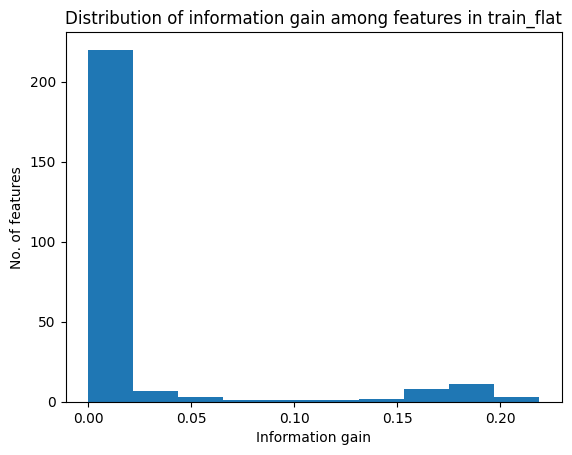

In [13]:
# Visualize 
print("Top 5 columns by information gain:")
print(col_info_gain[:5])
print("Bottom 5 columns by information gain:")
print(col_info_gain[-5:])

# Histogram of Information gain 
fig = plt.hist(col_info_gain)
plt.title("Distribution of information gain among features in train_flat")
plt.xlabel("Information gain")
plt.ylabel("No. of features")
plt.show()

We see that most features provide information gain in the bottom 10% percentile of all information gain scores. We choose to discard these. 

In [14]:
# Subset features
feature_sub_info_gain = list(col_info_gain[col_info_gain >= 0.025].index)
print("No. of features selected on the basis of Information Gain:", len(feature_sub_info_gain))


No. of features selected on the basis of Information Gain: 37


### Pairwise Pearson correlation

We calculate the pairwise Pearson correlation among the features and retain only features that are not strongly correlated with each other (i.e. show absolute correlation coefficient <= 0.99)

In [22]:
# Calculate pairwise Pearson correlation among all feature columns
pearson_corr = train_flat_norm.drop(columns=['attack_class']).corr(method='pearson')

with open('output/col_pearson_corr_mat', 'wb') as fp:
    pickle.dump(pearson_corr, fp)

<Figure size 3500x3500 with 0 Axes>

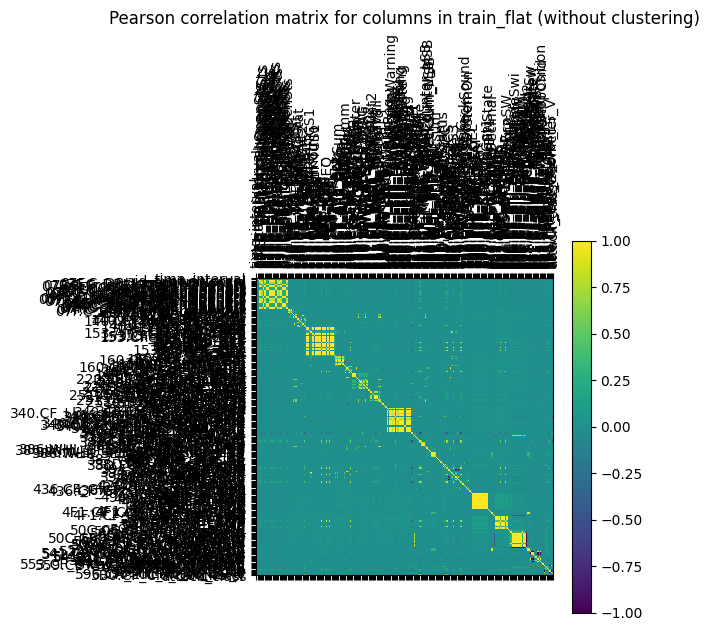

In [24]:
# Visualize correlation matrix
f = plt.figure(figsize=(35, 35))
# plt.matshow(pearson_corr, fignum=f.number)
plt.matshow(pearson_corr)
plt.xticks(range(train_flat_norm.select_dtypes(['number']).shape[1]), train_flat_norm.select_dtypes(['number']).columns, rotation=90)
plt.yticks(range(train_flat_norm.select_dtypes(['number']).shape[1]), train_flat_norm.select_dtypes(['number']).columns)
cb = plt.colorbar()
plt.title('Pearson correlation matrix for columns in train_flat (without clustering)')
plt.show()

In [25]:
# Identify features that show strong collinearity 

high_corr = set()
for i in range(len(pearson_corr.columns)):
    for j in range(i):
        if abs(pearson_corr.iloc[i, j]) > 0.99:
            high_corr.add(pearson_corr.columns[i])
print("No. of columns showing high correlation to other columns:", len(high_corr))
# print(high_corr)

# Discard features show strong collinearity 
feature_sub_pearson = [feat for feat in train_flat_norm.columns if (feat not in high_corr) and (feat != 'attack_class')]
print("No. of columns retained from pairwise Pearson correlation tests:", len(feature_sub_pearson))

No. of columns showing high correlation to other columns: 121
No. of columns retained from pairwise Pearson correlation tests: 136


### Feature variance

In [26]:
# Calculate feature variance
variance_selector = VarianceThreshold()
variance_selector.fit(train_flat_norm.drop(columns=['attack_class']))

VarianceThreshold()

In [27]:
# Convert to indexed Series for use later
col_variance = pd.Series(list(variance_selector.variances_), index=list(variance_selector.feature_names_in_))
col_variance = col_variance.sort_values(ascending=False)

# Save feature variances to disk
with open('output/col_variance', 'wb') as fp:
    pickle.dump(col_variance, fp)

Top 5 columns by feature variance:    4F1.CF_Clu_ParityBit1    0.250000
164.CF_Esc_Def           0.249797
153.TCS_DEF              0.247171
153.ESP_DEF              0.247171
153.HAC_DEF              0.247171
dtype: float64
Bottom 5 columns by feature variance: 4F1.CF_Clu_CruiseSwState    1.459203e-06
593.PRESSURE_FL             8.591074e-07
593.PRESSURE_RL             3.702610e-07
160.CR_Ahb_StDep_mm         3.236242e-08
5B0.CF_Clu_Odometer         1.543727e-09
dtype: float64


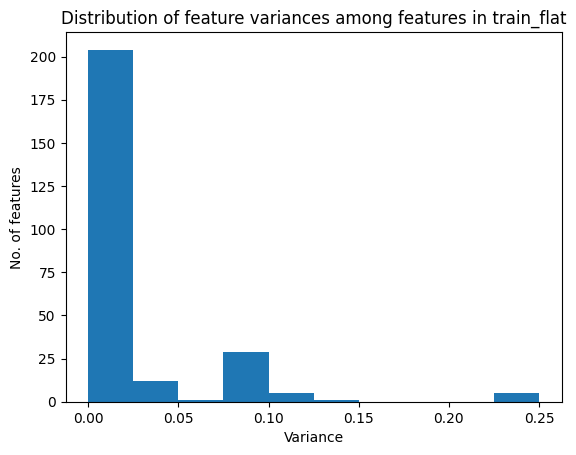

In [28]:
# Visualization
print("Top 5 columns by feature variance:   ", col_variance[:5])
print("Bottom 5 columns by feature variance:", col_variance[-5:])

# Histogram of variance
fig = plt.hist(col_variance)
plt.title("Distribution of feature variances among features in train_flat")
plt.xlabel("Variance")
plt.ylabel("No. of features")
plt.show()

We choose to discard the approximately 200 features that show variance of less than 0.025

In [29]:
# Retain features with high variance
feature_variance = list(col_variance[col_variance >= 0.025].index)
print("No. of features retained on the basis of feature variance:", len(feature_variance))

No. of features retained on the basis of feature variance: 53


### Final feature set

In this section we inspect the feature sets selected from information gain, pairwise pearson correlation tests, and feature variance. 

No. of features retained from information gain         : 37
No. of features retained from pearson correlation tests: 136
No. of features retained from feature variance         : 53


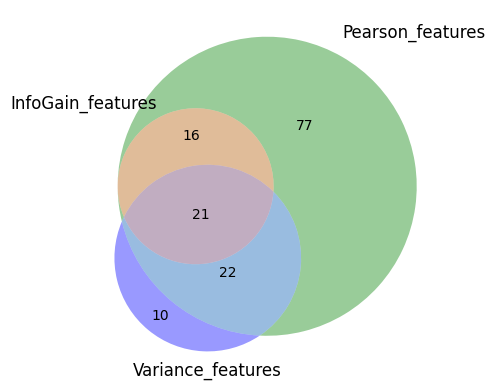

In [30]:
# Visualize feature sets
print("No. of features retained from information gain         :", len(feature_sub_info_gain))
print("No. of features retained from pearson correlation tests:", len(feature_sub_pearson))
print("No. of features retained from feature variance         :", len(feature_variance))

venn3([set(feature_sub_info_gain), set(feature_sub_pearson), set(feature_variance)], ('InfoGain_features', 'Pearson_features', 'Variance_features'))
plt.show()

We consider the features that are present in all three sets as the final feature set. 

In [31]:
# Intersection
final_colnames = set(feature_sub_info_gain).intersection(set(feature_sub_pearson).intersection(set(feature_variance)))

print("No. of features in final feature set:", len(final_colnames))
print("Final feature set:", final_colnames)

# Save final feature set to disk
with open('output/final_colnames', 'wb') as fp:
    pickle.dump(list(final_colnames), fp)

No. of features in final feature set: 21
Final feature set: {'140.CR_Yrs_MsgCnt2', '420.AliveCounterACC', '220.ESP12_AliveCounter', '2B0.CheckSum', 'arbitration_id', '421.CR_VSM_Alive', '394.CheckSum_TCS3', '394.AliveCounterTCS', '4F1.CF_Clu_VanzDecimal', '340.CF_Lkas_Chksum', '50C.CF_Clu_AliveCnt2', '4F1.CF_Clu_AliveCnt1', '153.AliveCounter_TCS1', '2B0.MsgCount', '421.CR_VSM_ChkSum', '340.CF_Lkas_MsgCount', '153.CheckSum_TCS1', '38D.CR_FCA_ChkSum', '130.CR_Yrs_MsgCnt1', '220.ESP12_Checksum', '164.CF_Esc_AliveCnt'}


In [32]:
# Save individual feature sets
with open('output/feature_sub_info_gain', 'wb' ) as fp:
    pickle.dump(list(feature_sub_info_gain), fp)

with open('output/feature_variance', 'wb') as fp:
    pickle.dump(list(feature_variance), fp)

with open('output/feature_sub_pearson', 'wb') as fp:
    pickle.dump(list(feature_sub_pearson), fp)

## Prepare data for model

We apply the preprocessing steps to each time window and save it as memory-mapped files for fast I/O during training and testing.

In [ ]:
reload(helper_functions)
from helper_functions import *

def writeMemoryMappedData(startidx, lnames, labels, colnames, minmax_vals, file_name, folder_name="model_data"):

    data_count = 0
    mmapped_array = np.memmap(folder_name + "/" + file_name + ".npy", dtype="float", mode="w+", shape=(len(startidx), 150, len(colnames)))

    pbar_count = len(startidx)               # Progress bar setup
    with tqdm(total = pbar_count) as pbar:   # Progress bar
        
        for lname in list(set(lnames)):

            # fp = "CSV_Signals_Multiclass/" + lname.rstrip(".log") + ".csv"
            fp = "signal_dataset/Attack/Real_attacks/" + lname
            df = pd.read_csv(fp)                            # Read in log

            df = df[[x for x in colnames if x != 'attack_class']] # Keep only selected columns
            if 'arbitration_id' in colnames:                # If AID is an included feature, convert it to integer
                df['arbitration_id'] = df.arbitration_id.apply(lambda x: int(x, 16))
            df = df.ffill()                                 # Forward-fill and delete NaN rows
            df = minMaxScaleWindowModel(df, minmax_vals)    # Minmax scaling

            indices = [(a,c) for a,b,c in zip(startidx, lnames, labels) if (b == lname) ]     # Get starting indices of all windows in current log
            
            for tup in indices:                     # Each tuple is (start index, window label)
                win = df.iloc[tup[0]:(tup[0]+150)]  # Window starting at tup[0]
                mmapped_array[data_count] = win
                data_count = data_count + 1      

                pbar.update(1)                      # Progress bar update

    mmapped_array.flush()

In [34]:
with open('output/final_colnames', 'rb') as fp:
    colnames = pickle.load(fp)
# with open('attack_lnames', 'rb')  as fp:    # Attack log names    
#     attack_lnames = pickle.load(fp)
attack_lnames = os.listdir("signal_dataset/Attack/Real_attacks/")
with open('output/minmax_vals', 'rb') as fp:
        minmax_vals = pickle.load(fp)

print("No. of features:", len(colnames))

No. of features: 21


In [ ]:
# Training data info
with open('model_data/startidx_train', 'rb') as fp:
        startidx = pickle.load(fp)
with open('model_data/lnames_train', 'rb') as fp:
    lnames = pickle.load(fp)
with open('model_data/labels_train', 'rb') as fp:
    labels = pickle.load(fp)

# Write training data to memory-mapped file
writeMemoryMappedData(startidx, lnames, labels, colnames, minmax_vals, "train_data", "model_data")

100%|██████████| 950332/950332 [07:27<00:00, 2125.07it/s] 


In [ ]:
# Validation data info
with open('model_data/startidx_val', 'rb') as fp:
        startidx = pickle.load(fp)
with open('model_data/lnames_val', 'rb') as fp:
    lnames = pickle.load(fp)
with open('model_data/labels_val', 'rb') as fp:
    labels = pickle.load(fp)

# Write validation data to memory-mapped file
writeMemoryMappedData(startidx, lnames, labels, colnames, minmax_vals, "val_data", "model_data")

100%|██████████| 316778/316778 [08:22<00:00, 630.67it/s] 


In [ ]:
# Testing data info
with open('model_data/startidx_test', 'rb') as fp:
    startidx = pickle.load(fp)
with open('model_data/lnames_test', 'rb') as fp:
    lnames = pickle.load(fp)
with open('model_data/labels_test', 'rb') as fp:
    labels = pickle.load(fp)

# Write testing data to memory-mapped file
writeMemoryMappedData(startidx, lnames, labels, colnames, minmax_vals, "test_data", "model_data")

100%|██████████| 316778/316778 [10:02<00:00, 525.61it/s] 


## Reorder columns according to hierarchical clustering

In [81]:
# Final column list
with open('output/final_colnames', 'rb') as fp:
    colnames = pickle.load(fp)

# Minimum and maximum values 
with open('output/minmax_vals', 'rb') as fp:
    minmax_vals = pickle.load(fp)

# Read in flat dataset
train_flat_norm = pd.read_csv("model_data/train_flat.csv", usecols=colnames)

# Scale
train_flat_norm = minMaxScaleWindow(train_flat_norm, minmax_vals)

In [82]:
# Pearson correlation coefficients
pearson_corr = train_flat_norm.corr(method='pearson')

<Figure size 3500x3500 with 0 Axes>

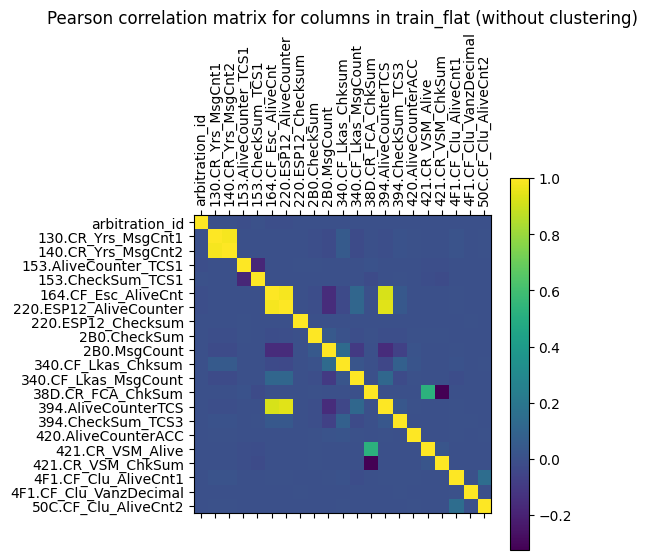

In [83]:
# Visualize correlation matrix
f = plt.figure(figsize=(35, 35))
# plt.matshow(pearson_corr, fignum=f.number)
plt.matshow(pearson_corr)
plt.xticks(range(train_flat_norm.select_dtypes(['number']).shape[1]), train_flat_norm.select_dtypes(['number']).columns, rotation=90)
plt.yticks(range(train_flat_norm.select_dtypes(['number']).shape[1]), train_flat_norm.select_dtypes(['number']).columns)
cb = plt.colorbar()
plt.title('Pearson correlation matrix for columns in train_flat (without clustering)')
plt.show()

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [20.0, 20.0, 42.5, 42.5],
  [5.0, 5.0, 31.25, 31.25],
  [105.0, 105.0, 115.0, 115.0],
  [95.0, 95.0, 110.0, 110.0],
  [85.0, 85.0, 102.5, 102.5],
  [75.0, 75.0, 93.75, 93.75],
  [125.0, 125.0, 135.0, 135.0],
  [84.375, 84.375, 130.0, 130.0],
  [65.0, 65.0, 107.1875, 107.1875],
  [145.0, 145.0, 155.0, 155.0],
  [175.0, 175.0, 185.0, 185.0],
  [165.0, 165.0, 180.0, 180.0],
  [150.0, 150.0, 172.5, 172.5],
  [195.0, 195.0, 205.0, 205.0],
  [161.25, 161.25, 200.0, 200.0],
  [86.09375, 86.09375, 180.625, 180.625],
  [18.125, 18.125, 133.359375, 133.359375]],
 'dcoord': [[0.0,
   np.float64(0.8244948511372189),
   np.float64(0.8244948511372189),
   0.0],
  [0.0, np.float64(0.47295399078976463), np.float64(0.47295399078976463), 0.0],
  [0.0,
   np.float64(0.9757897297400228),
   np.float64(0.9757897297400228),
   np.float64(0.47295399078976463)],
  [np.float64(0.8244948511372189),
   np.float64(0.99

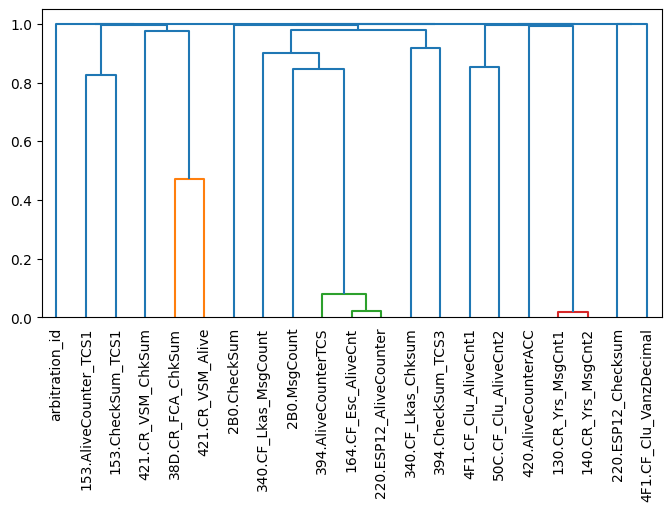

In [84]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance  import squareform

plt.figure(figsize=(8, 4))
dissimilarity = 1 - abs(pearson_corr)
Z = linkage (squareform(dissimilarity), 'complete')

dendrogram(Z, labels=train_flat_norm.columns, orientation='top', leaf_rotation=90)

<Figure size 3500x3500 with 0 Axes>

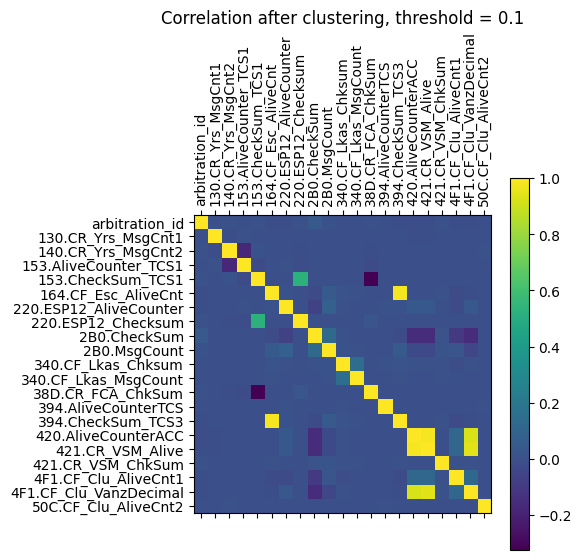

<Figure size 3500x3500 with 0 Axes>

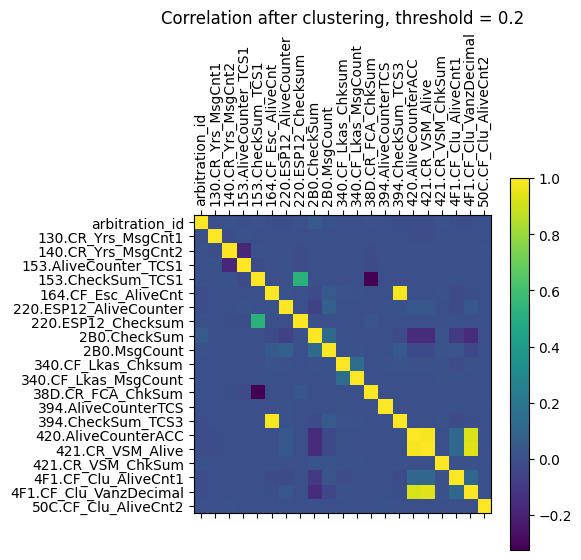

<Figure size 3500x3500 with 0 Axes>

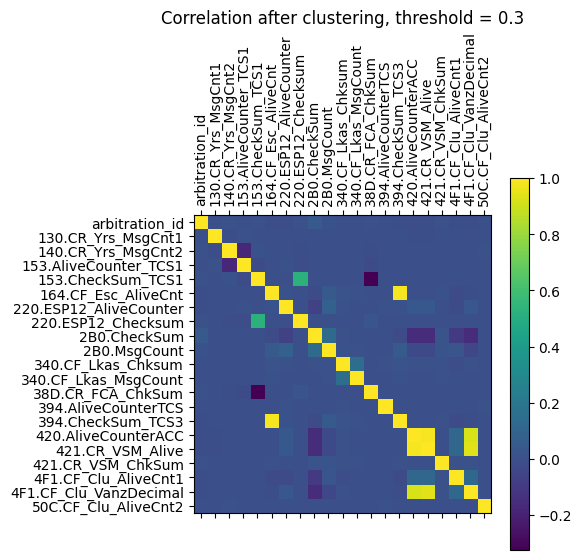

<Figure size 3500x3500 with 0 Axes>

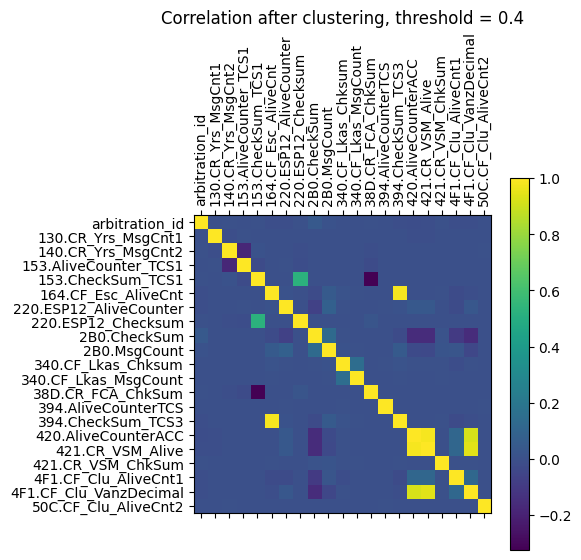

<Figure size 3500x3500 with 0 Axes>

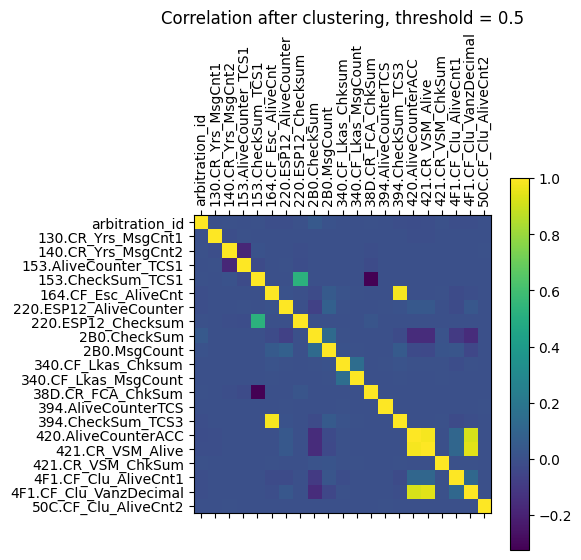

<Figure size 3500x3500 with 0 Axes>

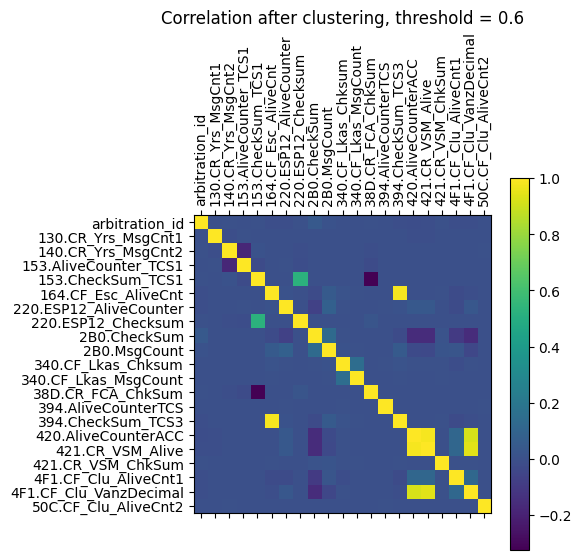

<Figure size 3500x3500 with 0 Axes>

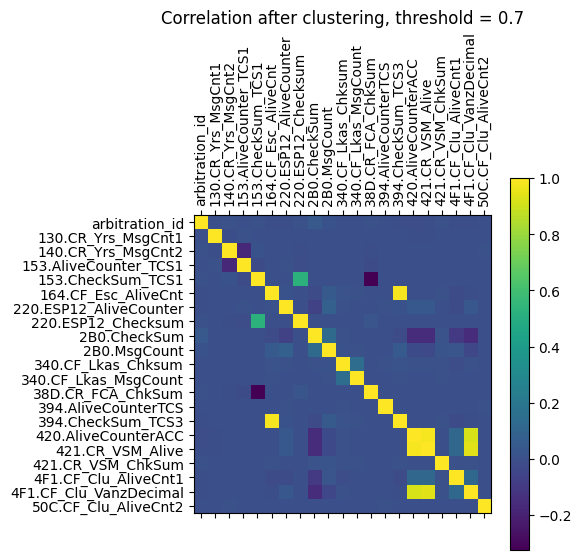

<Figure size 3500x3500 with 0 Axes>

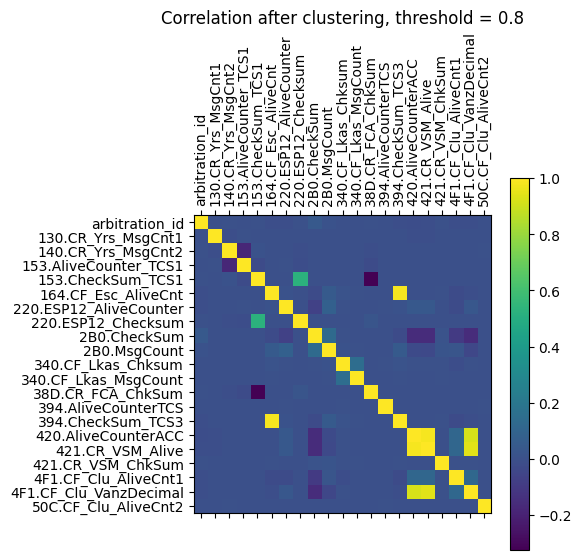

<Figure size 3500x3500 with 0 Axes>

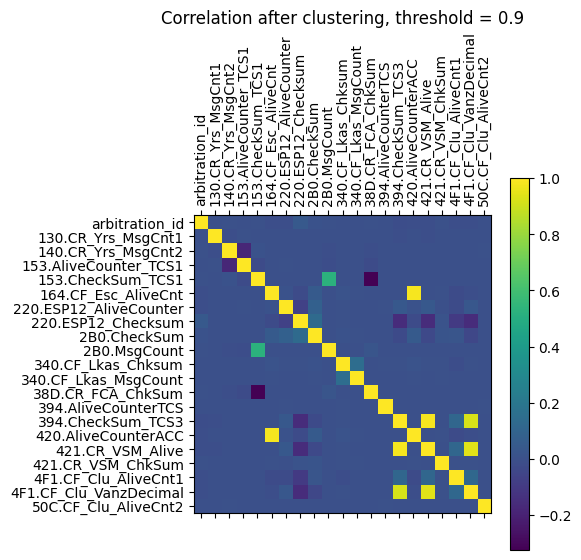

In [85]:
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    labels = fcluster(Z, threshold, criterion='distance')

    labels_order = np.argsort(labels)
    for idx, i in enumerate([colnames[i] for i in labels_order]):
        if idx == 0:
            clustered = pd.DataFrame(train_flat_norm[i])
        else:
            clustered = pd.concat([clustered, pd.DataFrame(train_flat_norm[i])], axis=1)

    pearson_corr = clustered.corr(method='pearson')

    f = plt.figure(figsize=(35, 35))
    plt.matshow(pearson_corr)
    plt.xticks(range(train_flat_norm.select_dtypes(['number']).shape[1]), train_flat_norm.select_dtypes(['number']).columns, rotation=90)
    plt.yticks(range(train_flat_norm.select_dtypes(['number']).shape[1]), train_flat_norm.select_dtypes(['number']).columns)
    cb = plt.colorbar()
    plt.title(f'Correlation after clustering, threshold = {threshold}')
    plt.show()
    

<Figure size 3500x3500 with 0 Axes>

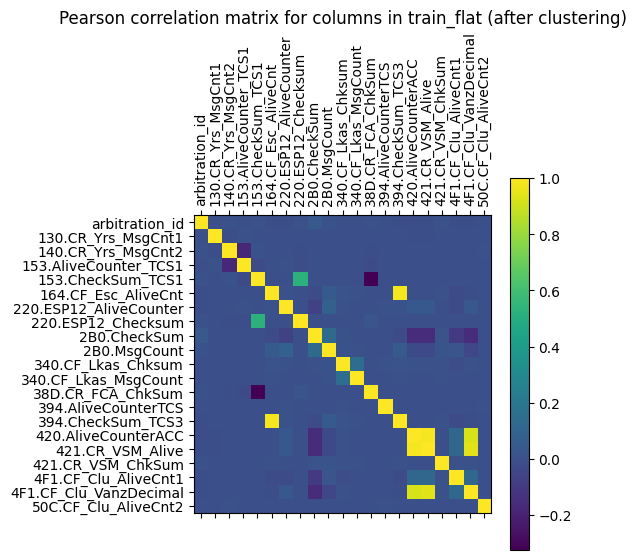

In [87]:
threshold = 0.8

labels = fcluster(Z, threshold, criterion='distance')
# print(labels)

labels_order = np.argsort(labels)
for idx, i in enumerate([colnames[i] for i in labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(train_flat_norm[i])
    else:
        clustered = pd.concat([clustered, pd.DataFrame(train_flat_norm[i])], axis=1)

# Pearson correlation coefficients
pearson_corr = clustered.corr(method='pearson')

# Visualize correlation matrix
f = plt.figure(figsize=(35, 35))
plt.matshow(pearson_corr)
plt.xticks(range(train_flat_norm.select_dtypes(['number']).shape[1]), train_flat_norm.select_dtypes(['number']).columns, rotation=90)
plt.yticks(range(train_flat_norm.select_dtypes(['number']).shape[1]), train_flat_norm.select_dtypes(['number']).columns)
cb = plt.colorbar()
plt.title('Pearson correlation matrix for columns in train_flat (after clustering)')
plt.show()

In [88]:
# Save reordered columns
with open('output/final_colnames_clustered', 'wb') as fp:
    pickle.dump(list(clustered.columns), fp)
print(len(clustered.columns))

21


## Prepare reordered data for model

Here, we apply hierarchical agglomerative clustering on the feature set retained and reorder them. This results in highly-correlated features being close to each other and uncorrelated features being further apart. 

In [90]:
with open('output/final_colnames_clustered', 'rb') as fp:
    colnames = pickle.load(fp)
# with open('attack_lnames', 'rb')  as fp:    # Attack log names    
#     attack_lnames = pickle.load(fp)
attack_lnames = os.listdir("signal_dataset/Attack/Real_attacks/")
with open('output/minmax_vals', 'rb') as fp:
        minmax_vals = pickle.load(fp)

print("No. of features:", len(colnames))

No. of features: 21


In [ ]:
# Training data info
with open('model_data/startidx_train', 'rb') as fp:
    startidx = pickle.load(fp)
with open('model_data/lnames_train', 'rb') as fp:
    lnames = pickle.load(fp)
with open('model_data/labels_train', 'rb') as fp:
    labels = pickle.load(fp)

# Write training data to memory-mapped file
writeMemoryMappedData(startidx, lnames, labels, colnames, minmax_vals, "train_data", "model_data_clustered")

100%|██████████| 950332/950332 [13:20<00:00, 1186.97it/s] 


In [ ]:
# Validation data info
with open('model_data/startidx_val', 'rb') as fp:
    startidx = pickle.load(fp)
with open('model_data/lnames_val', 'rb') as fp:
    lnames = pickle.load(fp)
with open('model_data/labels_val', 'rb') as fp:
    labels = pickle.load(fp)

# Write validation data to memory-mapped file
writeMemoryMappedData(startidx, lnames, labels, colnames, minmax_vals, "val_data", "model_data_clustered")

100%|██████████| 316778/316778 [13:10<00:00, 400.51it/s] 


In [ ]:
# Testing data info
with open('model_data/startidx_test', 'rb') as fp:
    startidx = pickle.load(fp)
with open('model_data/lnames_test', 'rb') as fp:
    lnames = pickle.load(fp)
with open('model_data/labels_test', 'rb') as fp:
    labels = pickle.load(fp)

# Write testing data to memory-mapped file
writeMemoryMappedData(startidx, lnames, labels, colnames, minmax_vals, "test_data", "model_data_clustered")

100%|██████████| 316778/316778 [12:55<00:00, 408.56it/s] 
